# Berlin Rental Market Analysis
#### Predictive modelling

In this section, I use supervised machine learning to predict total rent prices based on apartment features explored during the EDA phase.

I begin with a Linear Regression model to establish a baseline. This will help me see how well a basic, interpretable model can find patterns in the data. I then move on to more advanced models, including Random Forest and XGBoost, which are better suited for capturing complex, non-linear patterns between features.

Model performance will be evaluated using standard regression metrics such as R², RMSE, and MAE.

In [3]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBRegressor

I read a cleaned dataset that I saved at the end of EDA section.

In [6]:
# Load the dataset

df = pd.read_csv("/Users/alex/Documents/Work/Projects for portfolio/df_be_reg.csv")
print(df.columns, df.shape)

Index(['totalRent', 'livingSpace', 'noRooms', 'yearConstructed', 'heatingType',
       'condition', 'typeOfFlat', 'balcony', 'cellar', 'lift', 'garden',
       'hasKitchen', 'newlyConst', 'floor', 'regio3', 'Districts', 'rentM2',
       'geo_plz'],
      dtype='object') (9271, 18)


I can see that it still contains columns that are not useful for modelling (*regio3*, *geo_plz*), or can leak the data related to *totalRent* (like *rentM2* - total rent per square meter). I will reduce the dataset to only meaningful columns.

In [8]:
# Reduce the dataset to only meaningful columns

df = df[['totalRent', 'livingSpace', 'noRooms', 'yearConstructed', 'heatingType',
       'condition', 'typeOfFlat', 'balcony', 'cellar', 'lift', 'garden',
       'hasKitchen', 'newlyConst', 'floor', 'Districts']]
print(df.columns, df.shape)

Index(['totalRent', 'livingSpace', 'noRooms', 'yearConstructed', 'heatingType',
       'condition', 'typeOfFlat', 'balcony', 'cellar', 'lift', 'garden',
       'hasKitchen', 'newlyConst', 'floor', 'Districts'],
      dtype='object') (9271, 15)


In the next step, I separate the target variable, *totalRent*, from the rest of the features to prepare the data for training the model.

In [10]:
# Separate target and other features
X = df.drop(columns='totalRent')
y = df['totalRent']

## 1. Linear Regression

Based on data exploration, I know that my dataset includes categorical features (with object and boolean data types) and numerical features. Before training the model, these features need to be preprocessed.

I encode categorical values using one-hot encoding. The numerical features are on very different scales. For example, *floor* has values from 0 to 26, and *yearConstructed* ranges from the 1800s to 2010s. I apply scaling to make these features comparable for the model. The boolean features don’t need any transformation and can be passed through as they are.

As in the next step, I will build a pipeline, here, I use a ColumnTransformer to group all preprocessing together by column type.

In [13]:
# Define feature groups
categorical_cols = ['heatingType', 'condition', 'typeOfFlat', 'Districts']
boolean_cols = ['balcony', 'cellar', 'lift', 'garden', 'hasKitchen', 'newlyConst']
numeric_cols = ['livingSpace', 'noRooms', 'yearConstructed']

# Preprocessing
preprocessor_lr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols),
        ('bool', 'passthrough', boolean_cols)
    ]
)

I create a pipeline that applies the preprocessing steps using ColumnTransformer, I defined above, followed by training a Linear Regression model.

In [15]:
# Full pipeline with model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('model', LinearRegression())
])

As I’m training a simple Linear Regression model, I split the data 80/20 into training and test sets.

In [17]:
# Perform a test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['heatingType', 'condition',
                                                   'typeOfFlat', 'Districts']),
                                                 ('num', StandardScaler(),
                                                  ['livingSpace', 'noRooms',
                                                   'yearConstructed']),
                                                 ('bool', 'passthrough',
                                                  ['balcony', 'cellar', 'lift',
                                                   'garden', 'hasKitchen',
                                                   'newlyConst'])])),
                ('model', LinearRegression())])

Finally, I use the trained model to make predictions and evaluate its performance.

In [20]:
# Run prediction on the test set
y_pred_lr = pipeline.predict(X_test)

# Evaluate model performance
print("R² Score:", r2_score(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", root_mean_squared_error(y_test, y_pred_lr))

R² Score: 0.8296037643441144
MAE: 173.2175626082173
RMSE: 233.1322905899145


The linear regression model gives an **R²** of **0.83**, which means it explains about 83% of the variation in rental prices.
The **mean absolute error (MAE)** is around **173€**, and the **root mean squared error (RMSE)** is about **233€**, so while the model captures the general trends, some individual predictions can have larger errors. Considering the median total rent is about **1083€**, an average error of 173€ is quite significant, roughly 16% of the typical rent value. There's a possibility that properties with higher prices still affect the performance.

These results are a good starting point. Next, I’ll try more advanced models like Random Forest and XGBoost to see if they can better handle complex patterns in the data. I chose them because they handle mixed data types well, capture non-linear relationships, and generally offer stronger predictive performance on structured datasets.

## 2. Random Forest

Starting with Random Forest, I use the same train/test split and feature groups as before. Since Random Forest is a tree-based model and does not require feature scaling, I leave numerical features unprocessed and only apply encoding to categorical variables. This allows the model to naturally handle numerical and categorical data differently compared to Linear Regression.

In [24]:
# Preprocessing
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols),
        ('bool', 'passthrough', boolean_cols)
    ]
)

Building and fitting a pipeline for a Random Forest model.

In [26]:
# Pipeline with updated preprocessor for tree-based models
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('model', RandomForestRegressor(random_state=42))
])

# Fit the model
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['heatingType', 'condition',
                                                   'typeOfFlat', 'Districts']),
                                                 ('num', 'passthrough',
                                                  ['livingSpace', 'noRooms',
                                                   'yearConstructed']),
                                                 ('bool', 'passthrough',
                                                  ['balcony', 'cellar', 'lift',
                                                   'garden', 'hasKitchen',
                                                   'newlyConst'])])),
                ('model', RandomForestRegressor(random_state=42))])

With the pipeline ready, I’ll run predictions and evaluate the performance.

In [28]:
# Predict and evaluate
y_pred_rf = pipeline_rf.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))

R² Score: 0.8481508905735805
MAE: 154.087851945516
RMSE: 220.078976291648


The Random Forest model improved on the linear regression results, achieving an **R²** score of about **0.85**, which means it explains around 85% of the variation in rental prices. The **mean absolute error (MAE)** dropped to roughly **154€**, and the **root mean squared error (RMSE)** decreased to about **220€**. These improvements show that the model is better at capturing complex relationships in the data and making more accurate predictions overall.

### 2.1. Random Forest with GridSearchCV

Next, I’ll try to improve the model’s performance by tuning its hyperparameters using a grid search with cross-validation. This approach helps find the best combination of parameters to boost prediction accuracy. First, I’ll define the range of parameters to test:

In [32]:
# Set the parameter grid
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

I’ll run a grid search with 5-fold cross-validation to systematically test different hyperparameter combinations and select the best model based on the R² score. Using n_jobs=-1 speeds up the process by utilizing all available CPU cores, and verbose=1 provides progress updates during the search.

In [34]:
# Set up and run GridSearchCV

grid_search = GridSearchCV(
    pipeline_rf,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['heatingType',
                                                                          'condition',
                                                                          'typeOfFlat',
                                                                          'Districts']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['livingSpace',
                                                                          'noRooms',
                                                                          'yearConstructed']),
                                                                        ('bool',
                                                                         'passthrough',
                                                                         ['balcony',
                                                                          'cellar',
                                                                          'lift',
                                                                          'garden',
                                                                          'hasKitchen',
                                                                          'newlyConst'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='r2', verbose=1)

Here, I’m printing the best hyperparameters found by the grid search along with the best R² score from cross-validation. Then, I use the best model to predict on the test data and report the test R², MAE, and RMSE to see how well it performs on new data.

In [36]:
print("Best parameters:", grid_search.best_params_)
print("Best R² score (CV):", grid_search.best_score_)

# Evaluate on test set
best_model_rf = grid_search.best_estimator_
y_pred_rf_gs = best_model_rf.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred_rf_gs))
print("Test MAE:", mean_absolute_error(y_test, y_pred_rf_gs))
print("Test RMSE:", root_mean_squared_error(y_test, y_pred_rf_gs))

Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best R² score (CV): 0.8528934967961126
Test R²: 0.8492436053513939
Test MAE: 153.69589143932828
Test RMSE: 219.28569621394894


The best combination of hyperparameters found through grid search further improved the model's performance. The cross-validated **R²** score reached approximately **0.85**, and on the test set, the model achieved a slightly lower **R²** of **0.849**, meaning it explains about **85%** of the variation in rental prices.

The **MAE** slightly decreased but is still around **154€**, and the **RMSE** is about **219€**. While the improvements may seem insignificant, the tuning helped refine the model and reduce prediction errors.

## 3. XGBoost

For XGBoost, I use the same train/test split and feature groups as before. XGBoost is a tree-based model and doesn't require scaling of numerical features, so I leave them unprocessed. Categorical variables are kept encoded. XGBoost is known for its performance and flexibility, so I hope to see improved results.

For consistency, I will reassign the preprocessor.

In [40]:
# Preprocessing
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols),
        ('bool', 'passthrough', boolean_cols)
    ]
)

Next, I create a pipeline.

In [42]:
# Pipeline for XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

# Fit the model
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['heatingType', 'condition',
                                                   'typeOfFlat', 'Districts']),
                                                 ('num', 'passthrough',
                                                  ['livingSpace', 'noRooms',
                                                   'yearConstructed']),
                                                 ('bool', 'passthrough',
                                                  ['balcony', 'cellar', 'lift',
                                                   'garden', 'hasKitchen',
                                                   'newlyConst'])])),
                ('model',
                 XGBRegres...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, ...))])

Finally, I run the predictions and evaluate the model's performance.

In [44]:
y_pred_xgb = pipeline_xgb.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", root_mean_squared_error(y_test, y_pred_xgb))

R² Score: 0.8672524788668629
MAE: 146.75072788849286
RMSE: 205.77169862771171


XGBoost achieved better performance than the tuned Random Forest model, with an **R²** of about **0.87**, an **MAE** of approximately **147€**, and an **RMSE** of around **206€**. Despite not applying hyperparameter tuning yet, the model performed very well, and the sequential approach contributed to the improved results.

Next, I will try to tune the XGBoost model.

### 3.1. XGBoost with GridSearchCV

Now I’ll tune the hyperparameters of the XGBoost model using GridSearchCV, starting by defining the parameter grid.

In [48]:
# Define the parameter grid
param_grid_xgb = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__subsample': [0.8, 1.0]
}

Similar to Random Forest, I’ll now perform a grid search with 5-fold cross-validation, using the R² score to evaluate performance.

In [50]:
# Set up and run GridSearchCV

grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['heatingType',
                                                                          'condition',
                                                                          'typeOfFlat',
                                                                          'Districts']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['livingSpace',
                                                                          'noRooms',
                                                                          'yearConstructed']),
                                                                        ('bool',
                                                                         'passthrough',
                                                                         ['balcony',
                                                                          'cellar',
                                                                          'lift',
                                                                          'garden',
                                                                          'hasKitchen',
                                                                          'newlyCo...
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 5, 7],
                         'model__n_estimators': [100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

I will run the predictions and evaluate the model.

In [52]:
best_model_xgb_gs = grid_search_xgb.best_estimator_

y_pred_xgb_gs = best_model_xgb_gs.predict(X_test)

print("Best parameters:", grid_search_xgb.best_params_)
print("Test R²:", r2_score(y_test, y_pred_xgb_gs))
print("Test MAE:", mean_absolute_error(y_test, y_pred_xgb_gs))
print("Test RMSE:", root_mean_squared_error(y_test, y_pred_xgb_gs))


Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 0.8}
Test R²: 0.8706667903706934
Test MAE: 143.6348910481332
Test RMSE: 203.10820142602282


After tuning XGBoost with GridSearchCV, the evaluation metrics improved further, with an **R²** of about **0.87**, an **MAE** of roughly **143€**, and an **RMSE** of around **203€**.

I compared three models — Linear Regression, Random Forest, and XGBoost — using a similar preprocessing pipeline and the same train/test set. Tree models improved performance compared to Linear Regression, with tuned XGBoost achieving the best results.

## 4. Feature Importance

The XGBoost model has already demonstrated strong performance compared to other models. To ensure that the prediction accuracy has reached its potential limit for this dataset, I will now analyze feature importance based on the XGBoost model. This analysis will help determine whether reducing the dataset to the most important features can further improve the model.

First, I will extract feature names and importances from the pipeline and create a separate dataframe.

In [58]:
# Extract feature names from preprocessing
# For categorical features, get names from OneHotEncoder
cat_features = pipeline_xgb.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
# For numeric and boolean, use column names
num_bool_features = numeric_cols + boolean_cols
all_features = np.concatenate([cat_features, num_bool_features])

# Get feature importances from the XGBoost model
importances = pipeline_xgb.named_steps['model'].feature_importances_

# Create a DataFrame
feat_imp_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
})

feat_imp_df.head()

,feature,importance
0,heatingType_combined_heat_and_power_plant,0.003109
1,heatingType_district_heating,0.005650
2,heatingType_electric_heating,0.003857
3,heatingType_floor_heating,0.009903
4,heatingType_gas_heating,0.004148


The features in this DataFrame come from OneHotEncoder. I will create a new column to map each encoded feature back to its original feature. Then, I will sum the importances for each original feature.

In [60]:
# Map each encoded feature back to the original feature
def get_original_feature(feat_name):
    # For encoded categorical features, extract the base feature name before _
    if '_' in feat_name:
        return feat_name.split('_')[0]
    else:
        return feat_name  # numeric or boolean features

feat_imp_df['original_feature'] = feat_imp_df['feature'].apply(get_original_feature)

# Sum importances by original feature
agg_importance = feat_imp_df.groupby('original_feature')['importance'].sum().sort_values(ascending=False)

print(agg_importance)

original_feature
Districts          0.377130
livingSpace        0.213268
condition          0.099402
hasKitchen         0.064712
typeOfFlat         0.063236
heatingType        0.056945
lift               0.046425
yearConstructed    0.026383
noRooms            0.019108
newlyConst         0.010922
garden             0.008911
balcony            0.006876
cellar             0.006682
Name: importance, dtype: float32


Here we can see that *Districts* and *livingSpace* strongly influence the *totalRent* in the XGBoost model. At the same time, the features like *garden*, *balcony*, and *cellar* each contribute less than 1% importance.

For clarity, I will visualize these results in a plot:

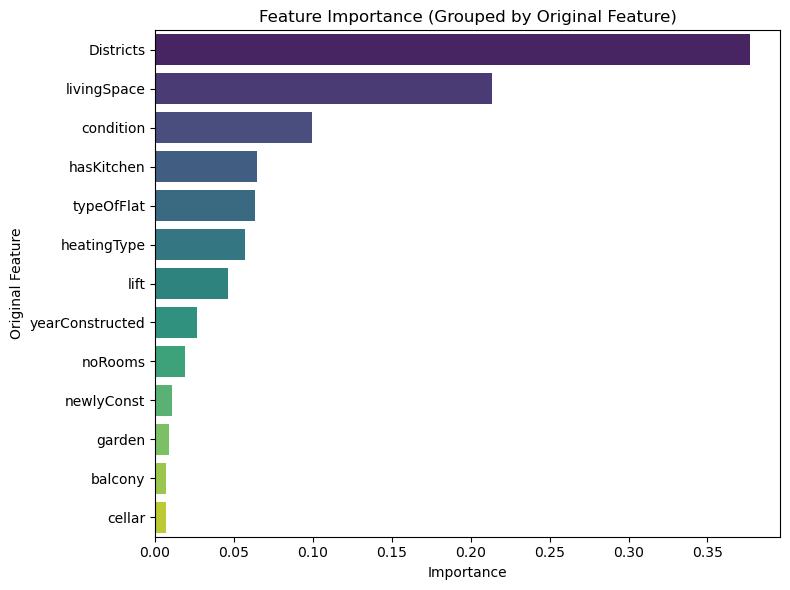

In [62]:
# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=agg_importance.values, y=agg_importance.index, palette='viridis', hue=agg_importance.index, legend=False)
plt.title('Feature Importance (Grouped by Original Feature)')
plt.xlabel('Importance')
plt.ylabel('Original Feature')
plt.tight_layout()
plt.show()

To reduce the dataset, I set a threshold and select only the features with importance values above it.

In [64]:
# Example threshold
threshold = 0.01

# Get features above threshold
selected_features = agg_importance[agg_importance > threshold].index.tolist()
print("Selected features:", selected_features)


Selected features: ['Districts', 'livingSpace', 'condition', 'hasKitchen', 'typeOfFlat', 'heatingType', 'lift', 'yearConstructed', 'noRooms', 'newlyConst']


The reduced dataset is ready, so I can return to modeling. I will use XGBoost again and follow the same steps as before, starting with setting up the preprocessor.

In [66]:
# Define feature groups
categorical_cols_r = [col for col in categorical_cols if col in selected_features]
boolean_cols_r = [col for col in boolean_cols if col in selected_features]
numeric_cols_r = [col for col in numeric_cols if col in selected_features]

# Preprocessing
preprocessor_xgb_r = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols_r),
        ('num', 'passthrough', numeric_cols_r),
        ('bool', 'passthrough', boolean_cols_r)
    ]
)

Next, I will create a pipeline.

In [68]:
# Set and fill the pipeline
pipeline_xgb_r = Pipeline(steps=[
    ('preprocessor', preprocessor_xgb_r),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

pipeline_xgb_r.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['heatingType', 'condition',
                                                   'typeOfFlat', 'Districts']),
                                                 ('num', 'passthrough',
                                                  ['livingSpace', 'noRooms',
                                                   'yearConstructed']),
                                                 ('bool', 'passthrough',
                                                  ['lift', 'hasKitchen',
                                                   'newlyConst'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=-1,
                              num_parallel_tree=None, ...))])

I run the predictions and evaluate the performance of XGBoost on reduced dataset.

In [70]:
y_pred_xgb_r = pipeline_xgb_r.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred_xgb_r))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb_r))
print("RMSE:", root_mean_squared_error(y_test, y_pred_xgb_r))

R² Score: 0.8646121261773232
MAE: 148.75646520699965
RMSE: 207.80802585473057


XGBoost with the reduced feature set still performed very well, achieving an **R²** of about **0.865**, an **MAE** of approximately **149€**, and an **RMSE** of around **208€**. Although slightly lower than the full-featured tuned model, these results confirm that the selected features retain most of the predictive power.

Using only the most important features (importance > 0.01), the XGBoost model maintained strong performance with only a slight drop in accuracy, indicating that a more compact feature set can still deliver reliable predictions.

## 5. Conclusion

I wiil bring the results off all the models into one dataframe.

In [74]:
# Initiate a dict of models
models = {
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'Tuned Random Forest': y_pred_rf_gs,
    'XGBoost': y_pred_xgb,
    'Tuned XGBoost': y_pred_xgb_gs,
    'XGBoost (Reduced Features)': y_pred_xgb_r
}
# Initiate a list of metrics
metrics = []

# Loop through each model and calculate metrics
for name, y_pred in models.items():
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    metrics.append([name, r2, mae, rmse])

# Create a DataFrame
df_be_reg_ml_summary = pd.DataFrame(metrics, columns=['Model', 'R²', 'MAE (€)', 'RMSE (€)'])

# Round values
df_be_reg_ml_summary = df_be_reg_ml_summary.round(2)

# Display the dataframe
df_be_reg_ml_summary

,Model,R²,MAE (€),RMSE (€)
0,Linear Regression,0.83,173.22,233.13
1,Random Forest,0.85,154.09,220.08
2,Tuned Random Forest,0.85,153.70,219.29
3,XGBoost,0.87,146.75,205.77
4,Tuned XGBoost,0.87,143.63,203.11
5,XGBoost (Reduced Features),0.86,148.76,207.81


Throughout this analysis, I compared several models using a consistent preprocessing pipeline. While the overall pipeline structure remained the same, I applied scaling to numeric features only in the Linear Regression model, as tree-based models do not require feature scaling. Tree-based models outperformed Linear Regression, with tuned XGBoost achieving the best overall results with **R² = 0.87**, **MAE ≈ 143.63€**, **RMSE ≈ 203.11€**.

To validate model robustness, I also analyzed feature importance and retrained XGBoost on a reduced feature set. The performance remained strong, indicating that a smaller, well-selected feature subset can still produce reliable predictions.

In the third part of this project, I will present key results and insights through interactive Tableau dashboards.

#### Exporting files for presentation

In [77]:
# Export the metrics to the file
df_be_reg_ml_summary.to_csv("/Users/alex/Documents/Work/Projects for portfolio/df_be_reg_ml_summary.csv", index=False)

In [78]:
# Export the dataset for presentation

# Add predicted values to the test dataframe
df_export = X_test.copy()

# Add actual target and predicted target columns
df_export['totalRent'] = y_test.values
df_export['y_pred_xgb_gs'] = y_pred_xgb_gs

# Export to CSV (or other format)
df_export.to_csv('/Users/alex/Documents/Work/Projects for portfolio/ml_results_export.csv', index=False)

In [79]:
# Export feature importance for presentation

# Convert to DataFrame
feat_imp_export = agg_importance.reset_index()
feat_imp_export.columns = ['feature', 'importance']

# Export to CSV
feat_imp_export.to_csv('/Users/alex/Documents/Work/Projects for portfolio/feature_importance_export.csv', index=False)